In [1]:
import numpy as np
import gym_minatar

# Generic replay buffer for standard gym tasks
class TaskBuffer(object):
    def __init__(self, state_shape, sf_dim, buffer_size, device):
        self.max_size = int(buffer_size)
        self.device = device

        self.ptr = 0
        self.crt_size = 0

        self.state = np.zeros((self.max_size, *state_shape))
        self.action = np.zeros((self.max_size, 1))
        self.next_state = np.zeros((self.max_size, *state_shape))
        # self.next_state = np.array(self.state)
        self.reward = np.zeros((self.max_size, 1))
        self.not_done = np.zeros((self.max_size, 1))
        self.task = np.zeros((self.max_size, sf_dim))


    def add(self, state, action, next_state, reward, done, task):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done
        self.task[self.ptr] = task

        self.ptr = (self.ptr + 1) % self.max_size
        self.crt_size = min(self.crt_size + 1, self.max_size)

    def sample(self, batch_size=32):
        ind = np.random.randint(0, self.crt_size, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.LongTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device),
            torch.FloatTensor(self.task[ind]).to(self.device),
        )


    def save(self, save_folder):
        np.save(f"{save_folder}_state.npy", self.state[:self.crt_size])
        np.save(f"{save_folder}_action.npy", self.action[:self.crt_size])
        np.save(f"{save_folder}_next_state.npy", self.next_state[:self.crt_size])
        np.save(f"{save_folder}_reward.npy", self.reward[:self.crt_size])
        np.save(f"{save_folder}_not_done.npy", self.not_done[:self.crt_size])
        np.save(f"{save_folder}_task.npy", self.task[:self.crt_size])
        np.save(f"{save_folder}_ptr.npy", self.ptr)


    def load(self, save_folder, size=-1):
        reward_buffer = np.load(f"{save_folder}_reward.npy")

        # Adjust crt_size if we're using a custom size
        size = min(int(size), self.max_size) if size > 0 else self.max_size
        self.crt_size = min(reward_buffer.shape[0], size)

        self.state[:self.crt_size] = np.load(f"{save_folder}_state.npy")[:self.crt_size]
        self.action[:self.crt_size] = np.load(f"{save_folder}_action.npy")[:self.crt_size]
        self.next_state[:self.crt_size] = np.load(f"{save_folder}_next_state.npy")[:self.crt_size]
        self.reward[:self.crt_size] = reward_buffer[:self.crt_size]
        self.not_done[:self.crt_size] = np.load(f"{save_folder}_not_done.npy")[:self.crt_size]
        self.task[:self.crt_size] = np.load(f"{save_folder}_task.npy")[:self.crt_size]
        print(f"Replay Buffer loaded with {self.crt_size} elements.")

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

import copy
from tqdm import tqdm
from dqn import DQN, Critic
import gym

import pickle

class ConvEncoder(nn.Module):
    def __init__(
        self,
        state_shape, # ex (4, 84, 84), (3, 7, 7)
        latent_dim,
    ):
        super().__init__()
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.state_shape = state_shape
        self.latent_dim = latent_dim
        
        def make_dummy_conv():
            encoder = nn.Linear(self.state_shape[0], self.latent_dim).to(device)
            return encoder
            
        def make_conv():
            conv = nn.Sequential(nn.Conv2d(state_shape[0], 32, 3, stride=1),
                                     nn.ReLU(), nn.Conv2d(32, 16, 3, stride=1),
                                     nn.ReLU()).to(device)
            sample = torch.zeros(1, *state_shape).to(device)
            size = torch.flatten(conv(sample)).shape[-1]
            encoder = nn.Sequential(conv, nn.Flatten(), nn.Linear(size, self.latent_dim), nn.ReLU()).to(device)
            return encoder
        
        if len(self.state_shape) < 2:
            self.encoder = make_dummy_conv()
        else:
            self.encoder = make_conv()
            
    def forward(self, state):
        return self.encoder(state)
    

class Phi(nn.Module):
    def __init__(
        self,
        latent_dim,
        hidden_dim,
        sf_dim,
    ):
        super().__init__()
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.phi = nn.Sequential(nn.Linear(latent_dim, hidden_dim), nn.ELU(),
                              nn.Linear(hidden_dim, hidden_dim), nn.ELU(),
                              nn.Linear(hidden_dim, sf_dim)).to(device)
        
    def forward(self, latent, norm=True):
        # in APS, we need to normalize the output
        out = self.phi(latent)
        out = F.normalize(out, dim=-1) if norm else out
        return out
    

class RMS(object):
    """running mean and std """
    def __init__(self, device, epsilon=1e-4, shape=(1,)):
        self.M = torch.zeros(shape).to(device)
        self.S = torch.ones(shape).to(device)
        self.n = epsilon

    def __call__(self, x):
        bs = x.size(0)
        delta = torch.mean(x, dim=0) - self.M
        new_M = self.M + delta * bs / (self.n + bs)
        new_S = (self.S * self.n + torch.var(x, dim=0) * bs +
                 torch.square(delta) * self.n * bs /
                 (self.n + bs)) / (self.n + bs)

        self.M = new_M
        self.S = new_S
        self.n += bs

        return self.M, self.S
    
class PBE(object):
    """particle-based entropy based on knn normalized by running mean """
    def __init__(self, rms, knn_clip, knn_k, knn_avg, knn_rms, device):
        self.rms = rms
        self.knn_rms = knn_rms
        self.knn_k = knn_k
        self.knn_avg = knn_avg
        self.knn_clip = knn_clip
        self.device = device

    def __call__(self, rep):
        source = target = rep
        b1, b2 = source.size(0), target.size(0)
        # (b1, 1, c) - (1, b2, c) -> (b1, 1, c) - (1, b2, c) -> (b1, b2, c) -> (b1, b2)
        sim_matrix = torch.norm(source[:, None, :].view(b1, 1, -1) -
                                target[None, :, :].view(1, b2, -1),
                                dim=-1,
                                p=2)
        reward, _ = sim_matrix.topk(self.knn_k,
                                    dim=1,
                                    largest=False,
                                    sorted=True)  # (b1, k)
        if not self.knn_avg:  # only keep k-th nearest neighbor
            reward = reward[:, -1]
            reward = reward.reshape(-1, 1)  # (b1, 1)
            reward /= self.rms(reward)[0] if self.knn_rms else 1.0
            reward = torch.maximum(
                reward - self.knn_clip,
                torch.zeros_like(reward).to(self.device)
            ) if self.knn_clip >= 0.0 else reward  # (b1, 1)
        else:  # average over all k nearest neighbors
            reward = reward.reshape(-1, 1)  # (b1 * k, 1)
            reward /= self.rms(reward)[0] if self.knn_rms else 1.0
            reward = torch.maximum(
                reward - self.knn_clip,
                torch.zeros_like(reward).to(
                    self.device)) if self.knn_clip >= 0.0 else reward
            reward = reward.reshape((b1, self.knn_k))  # (b1, k)
            reward = reward.mean(dim=1, keepdim=True)  # (b1, 1)
        reward = torch.log(reward + 1.0)
        return reward
    
class MiniAtarWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # self.observation_space = gym.spaces.Box(low=np.zeros((1, 13, 13)), high=np.ones((1, 13, 13)), dtype=np.uint8)
        # self.observation_space = gym.spaces.Box(low=np.zeros((7, 10, 10)), high=np.ones((7, 10, 10)), dtype=np.float32)
        size = env.observation_space.shape[-1]
        self.size = size
        low = env.observation_space.low.reshape((size, 10, 10))
        high = env.observation_space.high.reshape((size, 10, 10))
        dtype = env.observation_space.dtype
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=dtype)
    
    def observation(self, state):
        return state.transpose(2, 0, 1)
    
class SimAtariAug:
    def __init__(self, args):
        self.aug = nn.Sequential(nn.ReplicationPad2d(args.image_pad), transforms.RandomCrop((args.state_dim[-1], args.state_dim[-1])))

    def __call__(self, image):
        return self.aug(image)

class GridAPS(DQN):
    def __init__(
        self,
        env,
        conv=True,
        discount=0.99,
        lr_critic=1e-4,
        lr_encoder=1e-4, 
        latent_dim=256,
        hidden_dim=256,
        initial_eps=1,
        end_eps=0.1,
        eval_eps=0.1,
        pretrain_eps=1,
        eps_decay_period=int(2e4),
        target_update_frequency=200,
        double_q=False,
        # the following are variables for APS
        sf_dim=169,
        lr_phi=1e-4,
        lr_task=1e-4,
        update_task_frequency=5,
        knn_k=12,
        knn_rms=True,
        knn_avg=True,
        knn_clip=1e-4,
        # flag for separate encoder
        separate_encoder=True,
    ):
        # for APS 
        self.sf_dim = sf_dim
        self.lr_phi = lr_phi
        self.lr_task = lr_task
        self.update_task_frequency = update_task_frequency
        self.knn_k = knn_k
        self.knn_rms = knn_rms
        self.knn_avg = knn_avg
        self.knn_clip = knn_clip
        self.temp_task = None # temp tasks are set through function : set_task
        
        self.separate_encoder = separate_encoder
        
        super().__init__(
            env=MiniAtarWrapper(env),
            conv=conv,
            discount=discount,
            lr_critic=lr_critic,
            lr_encoder=lr_encoder,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            initial_eps=initial_eps,
            end_eps=end_eps,
            eval_eps=eval_eps,
            pretrain_eps=pretrain_eps,
            eps_decay_period=eps_decay_period,
            target_update_frequency=target_update_frequency,
            double_q=double_q,
        )
        
        self.env_name = str(self.env)
        
    def _make_alias(self):
        self.SF1 = self.critic.get_SF1
        self.SF = self.critic.get_SFs
        self.SF1_target = self.critic_target.get_SF1
        self.SF_target = self.critic_target.get_SFs
        
        # to get Q's, one need 'task' (a k-dim vector)
        self.Q1 = self.critic.get_Q1
        self.Q = self.critic.get_Qs
        self.Q1_target = self.critic_target.get_Q1
        self.Q_target = self.critic_target.get_Qs
        
    def _define_networks(self):
        self.encoder = ConvEncoder(
            state_shape=self.state_shape,
            latent_dim=self.latent_dim,
        )
        
        self.phi = Phi(
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            sf_dim=self.sf_dim,
        )

        
        self.critic = Critic(
            latent_dim=self.latent_dim + self.sf_dim, # input is cat([latent, task])
            hidden_dim=self.hidden_dim, 
            num_actions=self.num_actions,
            sf_dim=self.sf_dim
        )
        self.critic_target = copy.deepcopy(self.critic)
        
        self.RMS = RMS(self.device)
        self.PBE = PBE(
            rms=self.RMS, 
            knn_clip=self.knn_clip, 
            knn_k=self.knn_k,
            knn_avg=self.knn_avg,
            knn_rms=self.knn_rms,
            device=self.device
        )
        
        self.encoder_opt = torch.optim.Adam(self.encoder.parameters(), lr=self.lr_encoder)
        self.phi_opt = torch.optim.Adam(self.phi.parameters(), lr=self.lr_phi)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        
        self.task_learned = False
        self.task = torch.ones((1, self.sf_dim), requires_grad=True, device=self.device) # task is only for RL phase (supervised learning phase)
        self.task_opt = torch.optim.Adam([self.task], lr=self.lr_task)
        
        if self.separate_encoder:
            self.encoder_critic = ConvEncoder(
                state_shape=self.state_shape,
                latent_dim=self.latent_dim,
            )
            self.encoder_critic_opt = torch.optim.Adam(self.encoder_critic.parameters(), lr=self.lr_critic)
            
        else:
            self.encoder_critic = self.encoder
        
    def set_fine_tuning(self): # follow the hyperparameters that APS paper provide
        # del self.task_opt
        del self.critic_opt
        # del self.encoder_critic_opt
        # self.task_opt = torch.optim.Adam([self.task], lr=1e-3)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=1e-3)
        if self.separate_encoder:
            del self.encoder_critic_opt
            self.encoder_critic_opt = torch.optim.Adam(self.encoder_critic.parameters(), lr=1e-3)
        self.target_update_frequency = 100
        
    def intrinsic_reward(self, task, next_latent):
        # maxent reward
        with torch.no_grad():
            state_representation = self.phi(next_latent, norm=False)
        bonus = self.PBE(state_representation)
        ent_bonus = bonus.view(-1, 1)

        # successor feature reward
        state_representation = state_representation / torch.norm(state_representation, dim=1, keepdim=True)
        sf_reward = torch.einsum("bi,bi->b", task, state_representation).reshape(-1, 1)

        return ent_bonus, sf_reward
    
    def maybe_set_task(self, fine_tune):
        if fine_tune:
            return self.task
        elif (self.iterations + 1) % self.update_task_frequency:
            return self.set_task()
        
        return self.temp_task
    
    def set_task(self):
        task = torch.randn(self.sf_dim).to(self.device)
        task = task / torch.norm(task)
        self.temp_task = task
        return task
    
    def make_replay_buffer(self, buffer_size=int(3e5)):
        return TaskBuffer(self.state_shape, self.sf_dim, buffer_size, self.device)
    
    def select_action(self, state, task, eval=False, pretrain=True):
        # this function affects evaluation funciton
        if eval: # if eval, we don't care if we are pretraining or not
            eps = self.eval_eps
        elif pretrain: # if pretrain, we use pretrain eps
            eps = self.pretrain_eps
        else:
            eps = max(self.slope * self.iterations + self.initial_eps, self.end_eps)

        # Select action according to policy with probability (1-eps)
        # otherwise, select random action
        if np.random.uniform(0,1) > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).reshape(self.state_shape).unsqueeze(0).to(self.device)                    
                if type(task) == np.ndarray:
                    task = torch.from_numpy(task).to(self.device)
                task = task.float().view(1, task.shape[-1])
                
                latent = self.encoder_critic(state)
                
                # cat latent and task for universal successor feature
                latent = torch.cat([latent, task], dim=1)
                return int(self.Q1(latent, task).argmax(1))
        else:
            return np.random.randint(self.num_actions)
    
    def train(self, replay_buffer, batch_size=128, fine_tune=False):
        state, action, next_state, reward, not_done, task = replay_buffer.sample(batch_size=batch_size)
        
        latent = self.encoder(state)
        next_latent = self.encoder(next_state)
        
        latent_critic = self.encoder_critic(state)
        next_latent_critic = self.encoder_critic(next_state)
        
        # calculate the adjusted reward
        if fine_tune:
            reward = reward # even when we are finetuning, use the task got from the replay_buffer
            # task = self.task.repeat(batch_size, 1) # use the regressed task
        else:
            with torch.no_grad():
                ent_bonus, sf_reward = self.intrinsic_reward(task, next_latent)
                aps_reward = ent_bonus + sf_reward
                reward = aps_reward
            # calculte Phi-loss
            phi_loss = - torch.einsum("bi,bi->b", self.phi(next_latent), task).mean()
            # update Phi and Encoder
            self.encoder_opt.zero_grad()
            self.phi_opt.zero_grad()
            phi_loss.backward()
            self.encoder_opt.step()
            self.phi_opt.step()
        
        # cat latent and task, for universal SF approximator
        # we don't update encoder based on Q-loss
        # use the latent vector produced by encoder_critic
        latent = torch.cat([latent_critic, task], dim=1)
        next_latent = torch.cat([next_latent_critic, task], dim=1)
        if not self.separate_encoder:
            latent = latent.detach()
            next_latent = next_latent.detach()
        
        # calculate Q-loss
        with torch.no_grad():
            next_action = self.Q1(next_latent, task).argmax(1, keepdim=True)
            if self.double_q:
                target_Q1, target_Q2 = self.Q_target(next_latent, task)
                target_Q1, target_Q2 = (
                    target_Q1.gather(1, next_action).view(-1, 1),
                    target_Q2.gather(1, next_action).view(-1, 1)
                )
                target_Q = torch.min(target_Q1, target_Q2)
            else:
                target_Q = self.Q1_target(next_latent, task).gather(1, next_action).view(-1, 1)
            
            # print(f'reward : {reward}, not_done : {not_done}, next_action :{next_action}, target_Q : {target_Q}')
            target_Q = reward + not_done * self.discount * target_Q
            
        
        if self.double_q:
            Q1, Q2 = self.Q(latent, task)
            Q1, Q2 = (
                Q1.gather(1, action).view(-1, 1),
                Q2.gather(1, action).view(-1, 1)
            )
            
            Q_loss = F.mse_loss(Q1, target_Q) + F.mse_loss(Q2, target_Q)
        else:
            Q = self.Q1(latent, task).gather(1, action).view(-1, 1)
            Q_loss = F.mse_loss(Q, target_Q)
        
        # update Q-networks
        # print(f'Q-loss : {Q_loss}, Q : {Q}, Q_target : {target_Q}')
        # print(Q_loss.mean())
        if self.separate_encoder:
            self.critic_opt.zero_grad()
            self.encoder_critic_opt.zero_grad()
            Q_loss.backward()
            self.critic_opt.step()
            self.encoder_critic_opt.step()
        else:
            self.critic_opt.zero_grad()
            Q_loss.backward()
            self.critic_opt.step()
        
        # update target network
        self.copy_target_update()
        
    def maybe_regress_task(self, replay_buffer, batch_size, step_size=1, fine_tune=False):
        if fine_tune:
            print("Error: fine-tuning, cannot update the task")  # we do not regress_task during fine-tuning
        
        if replay_buffer.crt_size > 4096 and self.iterations % self.update_task_frequency == 0:
            return self.regress_task(replay_buffer, batch_size, step_size)
        
    def regress_task(self, replay_buffer, batch_size=32, step_size=1):
        # there are two options, one is using gradient descent, the other is using torch.linalg.lstsq
        self.task_learned = True
        loss_log = []
        for epoch in tqdm(range(step_size)):
            state, action, next_state, reward, *_ = replay_buffer.sample(batch_size=batch_size)
            with torch.no_grad():
                next_latent = self.encoder(state)
                # next_latent = self.encoder(state)
                representation = self.phi(next_latent)
                
            # estimate the reward
            estimated_reward = torch.einsum("bi,bi->b", representation, self.task.repeat(batch_size, 1)) # 256 by 169, 1 by 169
            
            # update the task
            task_loss = F.mse_loss(reward, estimated_reward)
            self.task_opt.zero_grad()
            task_loss.backward()
            self.task_opt.step()
            loss_log.append(task_loss.data.cpu().numpy())
            
        self.task = self.task / torch.norm(self.task)
            
        return loss_log
    
    def regress_task_lstsq(self, replay_buffer):
        self.task_learned = True
        obs, reward = [], []
        batch_size = 0
        while batch_size < min(int(1e6), replay_buffer.crt_size):
            _, _, batch_obs, batch_reward, *_ = replay_buffer.sample(256)
            obs.append(batch_obs)
            reward.append(batch_reward)
            batch_size += batch_obs.size(0)
        obs, reward = torch.cat(obs, 0), torch.cat(reward, 0)

        obs = self.encoder(obs)
        rep = self.phi(obs)
        print(rep.shape, reward.shape)
        task = torch.linalg.lstsq(reward, rep)[0][:rep.size(1), :][0]
        task = task / torch.norm(task)
#         task = task.cpu().numpy()
#         meta = OrderedDict()
#         meta['task'] = task

        # save for evaluation
        self.task = task

                
    def learn(self, replay_buffer, step_size, learn_task=False, learning_start=int(1e4), batch_size=32, fine_tune=False, log_freq=int(5e3)):
        if replay_buffer is None:
            replay_buffer = self.make_replay_buffer()
            
        state = self.env.reset()
        episodic_return = 0
        episode_length = 0
        episode_num = 0
        task = self.set_task()
        evaluations = []
        
        for step in tqdm(range(step_size)):
            self.iterations += 1
            # pick action and transit in the env
            task = self.maybe_set_task(fine_tune)
            if step < learning_start:
                action = self.env.action_space.sample()
            else:
                action = self.select_action(state, task, eval=False, pretrain=(not fine_tune))
            next_state, reward, done, info = self.env.step(action)
            
            # add the experience into the buffer
            replay_buffer.add(state, action, next_state, reward, done, task.cpu().data.numpy())
            if replay_buffer.crt_size > learning_start:
                if fine_tune and learn_task:
                    self.regress_task(replay_buffer, batch_size=256, step_size=1)
                self.train(replay_buffer, batch_size=batch_size, fine_tune=fine_tune)
            
            # update iterative values
            state = next_state
            episodic_return += reward
            episode_length += 1
            
            # maybe evaluate
            if fine_tune and (step + 1) % log_freq == 0:
                evaluations.append(self.evaluate(fine_tune))
            
            # check if the episode ends
            if done:
                if fine_tune:
                    print(f"====== Total T: {step+1} Episode Num: {episode_num+1} Episode_Length T: {episode_length} Return: {episodic_return:.3f} ======")
                episode_num += 1
                state = self.env.reset()
                episodic_return = 0
                episode_length = 0
                
        # loss = self.maybe_regress_task(replay_buffer, batch_size=1024, step_size=int(4e4), fine_tune=fine_tune)
                
        return evaluations
    
    def evaluate(self, fine_tune, seed=0, eval_episodes=5, max_step_size=int(125e3)):
        eval_env = copy.deepcopy(self.env)
        eval_env.seed(seed + 100)

        avg_reward = 0.
        step = 0
        task = self.maybe_set_task(fine_tune)
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            step = 0
            while not done and step < max_step_size:
                step += 1
                action = self.select_action(np.array(state), task, eval=True)
                state, reward, done, _ = eval_env.step(action)
                avg_reward += reward

        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward
    
    def save(self, filename=None):
        assert self.task_learned, 'need to identify the task first'
        filename = f'models/{self.env_name}-{self.update_task_frequency}-{self.separate_encoder}' if filename is None else filename
        torch.save(self.critic.state_dict(), filename + "_critic")
        torch.save(self.critic_opt.state_dict(), filename + "_critic_opt")

        torch.save(self.encoder.state_dict(), filename + "_encoder")
        torch.save(self.encoder_opt.state_dict(), filename + "_encoder_opt")

        torch.save(self.phi.state_dict(), filename + "_phi")
        torch.save(self.phi_opt.state_dict(), filename + "_phi_opt")
        
        torch.save(self.task, filename + "_task.pt")



    def load(self, filename=None):
        filename = f'models/{self.env_name}-{self.update_task_frequency}-{self.separate_encoder}' if filename is None else filename
        self.critic.load_state_dict(torch.load(filename + "_critic"))
        self.critic_opt.load_state_dict(torch.load(filename + "_critic_opt"))
        self.critic_target = copy.deepcopy(self.critic)

        self.encoder.load_state_dict(torch.load(filename + "_encoder"))
        self.encoder_opt.load_state_dict(torch.load(filename + "_encoder_opt"))
        self.encoder_critic = self.encoder

        self.phi.load_state_dict(torch.load(filename + "_phi"))
        self.phi_opt.load_state_dict(torch.load(filename + "_phi_opt"))
        
        self.task = torch.load(filename + "_task.pt")

    def collect_replay_buffer(self, size=int(1e6)):
        replay_buffer = self.make_replay_buffer(size)
        state = self.env.reset()
        done = False
        task = self.set_task()
        for step in tqdm(range(size)):
            set_task = (step + 1) % self.update_task_frequency
            if set_task:
                task = self.maybe_set_task(fine_tune=False)
            action = self.select_action(state, task, eval=False, pretrain=True)
            next_state, reward, done, info = self.env.step(action)
            replay_buffer.add(state, action, next_state, reward, done, task.cpu().data.numpy())
            state = next_state
            if done:
                done = False
                state = self.env.reset()
                
        return replay_buffer
            
    def combine_encoder(self):
        assert self.separate_encoder == True, 'there is only one encoder(encoder_phi), no need to combine'
        self.separate_encoder = False
        self.encoder_critic = self.encoder
        del self.encoder_critic_opt

In [3]:
import gym_minatar
# env = FourRooms(config=2, layout='4rooms')
env = gym.make('Breakout-MinAtar-v0')
aps = GridAPS(
    env, 
    conv=False,
    eval_eps=0,
    pretrain_eps=0.1,
    eps_decay_period=int(2e3),
    double_q=False,
    sf_dim=5,
    latent_dim=256,
    update_task_frequency=5,
    target_update_frequency=50,
    separate_encoder=False,
    lr_task=1e-4,
    lr_encoder=1e-4,
    lr_critic=1e-4,
    lr_phi=1e-4,
)

In [21]:
f'models/{aps.env_name}-{aps.update_task_frequency}-{aps.separate_encoder}'

'models/<MiniAtarWrapper<SeaquestEnv<Seaquest-MinAtar-v0>>>-100-False'

In [4]:
replay_buffer = aps.make_replay_buffer(buffer_size=int(1e6))
e = aps.learn(replay_buffer, step_size=int(1e6), batch_size=32, fine_tune=False, log_freq=int(1e5), learning_start=int(2e3))
aps.regress_task_lstsq(replay_buffer)
loss = aps.regress_task(replay_buffer, batch_size=256, step_size=int(1e4))

100%|██████████| 1000000/1000000 [2:55:22<00:00, 95.04it/s]  


torch.Size([1000192, 5]) torch.Size([1000192, 1])


  0%|          | 1/10000 [00:01<5:11:05,  1.87s/it]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
aps.save()

In [16]:
aps.load()

In [ ]:
aps.task

In [18]:
replay_buffer = aps.collect_replay_buffer()

 10%|█         | 104523/1000000 [01:37<13:58, 1067.72it/s]


KeyboardInterrupt: 

In [ ]:
loss = aps.regress_task(replay_buffer, batch_size=256, step_size=int(4e4))

In [ ]:
## aps.set_fine_tuning()
ft_rp = aps.make_replay_buffer()
evaluations = aps.learn(
    ft_rp,
    step_size=int(1e6),
    learning_start=int(2e3),
    batch_size=32,
    fine_tune=True
)

In [11]:
aps.env.reward_range

(-inf, inf)

In [8]:
torch.cuda.is_available()

True

In [5]:
aps.critic.device

device(type='cuda')

ERROR! Session/line number was not unique in database. History logging moved to new session 801


In [11]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('Seaquest-MinAtar-Pretrained')

NameError: name 'evaluations' is not defined

Text(0.5, 1.0, 'Breakout-MinAtar-Pretrained')

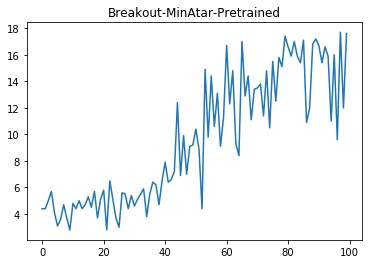

In [26]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('Breakout-MinAtar-Pretrained')

Text(0.5, 1.0, 'Seaquest-MinAtar-Pretrained')

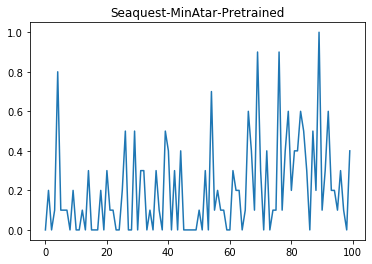

In [12]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('Seaquest-MinAtar-Pretrained')

Text(0.5, 1.0, 'SpaceInvaders-MinAtar-Pretrained')

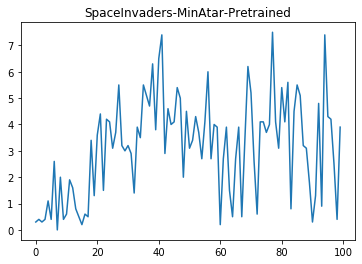

In [22]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('SpaceInvaders-MinAtar-Pretrained')

Text(0.5, 1.0, 'SpaceInvaders-MinAtar-Pretrained')

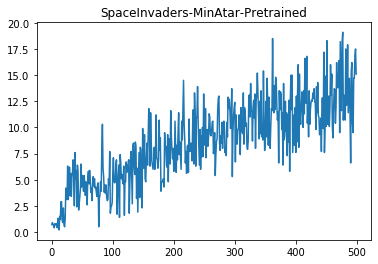

In [13]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('SpaceInvaders-MinAtar-Pretrained')

Text(0.5, 1.0, 'aps fourrooms, conv encoder, layout=4rooms')

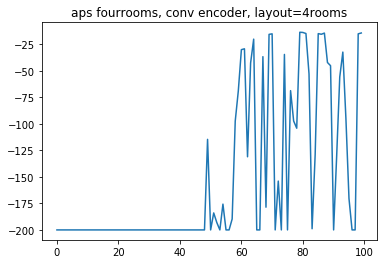

In [17]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms, conv encoder, layout=4rooms')

Text(0.5, 1.0, 'aps fourrooms, conv encoder, layout=open')

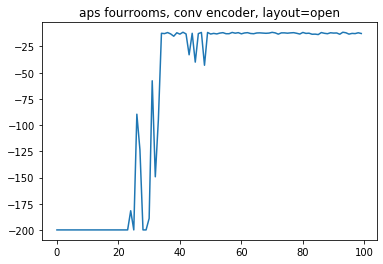

In [14]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms, conv encoder, layout=open')

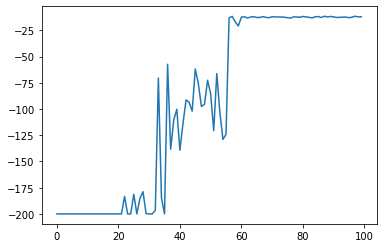

In [70]:
import matplotlib.pyplot as plt

plt.plot(evaluations, title='aps after pretraini')